# / Introduction

## Objective

The objective of this analysis and modeling is trying to answer the question below.

> [Predict confirmed COVID-19 cases among suspected cases](https://www.kaggle.com/einsteindata4u/covid19/tasks?taskId=645)

## Data

The data used was provided by Albert Einstein Hospital from Brazil.

The target that we will trying to predict is `SARS-Cov-2 exam result`.

> If value is `1` the exam to SARS-Cov-2 was **positive**.

> If value is `0` the exam to SARS-Cov-2 was **negative**.

## Alerts

- This dataset doesn't has a metadata available, but I'll describe some variables based on their names.
- I don't have access to a doctor to provide health knowledge for this study. Then, the results from this analysis is invalid to use as real conclusions.

## / Imports, variables and configs setting.

In [1]:
import numpy as np
import pandas as pd
import json
import pandas_profiling as pdp
import missingno
from tqdm import tqdm
from IPython.core.display import HTML, Image
import os

# graphs
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

In [25]:
# Variables
pandas_profiling_executor = True
pandas_profiling_file = "covid-19_br_einsteindata4u.html"
pandas_profiling_link = "https://github.com/DougTrajano/ds_covid-19_brazil/blob/master/airbnb_data_report.html"
target_col = "SARS-Cov-2 exam result"
file_path = "kaggle/input/covid19/dataset.xlsx"

## / Load file

In [26]:
print(file_path)
df = pd.read_excel(file_path)

print(df.shape)
df.head()

kaggle/input/covid19/dataset.xlsx
(5644, 111)


,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
# / Data Transformation and Exploratory analysis

I decided to transform the data and explore it in the same time.

## / Check missing Values

Unfortunally, almost all columns have more than 90% of missing data.

In [4]:
df_missing = []
for col in df.columns:
    missing = round((len(df[df[col].notnull()]) / len(df))*100, 2)
    missing = abs(missing - 100)
    df_missing.append({"column": col, "missing percentage": missing})
    if missing == 0:
        print("Column {col} has no missing values.".format(col=col))
    else:
        print("Column {col} has {missing}% of missing values.".format(col=col, missing=missing))

df_missing = pd.DataFrame(df_missing)

Column Patient ID has no missing values.
Column Patient age quantile has no missing values.
Column SARS-Cov-2 exam result has no missing values.
Column Patient addmited to regular ward (1=yes, 0=no) has no missing values.
Column Patient addmited to semi-intensive unit (1=yes, 0=no) has no missing values.
Column Patient addmited to intensive care unit (1=yes, 0=no) has no missing values.
Column Hematocrit has 89.32% of missing values.
Column Hemoglobin has 89.32% of missing values.
Column Platelets has 89.33% of missing values.
Column Mean platelet volume  has 89.39% of missing values.
Column Red blood Cells has 89.33% of missing values.
Column Lymphocytes has 89.33% of missing values.
Column Mean corpuscular hemoglobin concentration (MCHC) has 89.33% of missing values.
Column Leukocytes has 89.33% of missing values.
Column Basophils has 89.33% of missing values.
Column Mean corpuscular hemoglobin (MCH) has 89.33% of missing values.
Column Eosinophils has 89.33% of missing values.
Colum

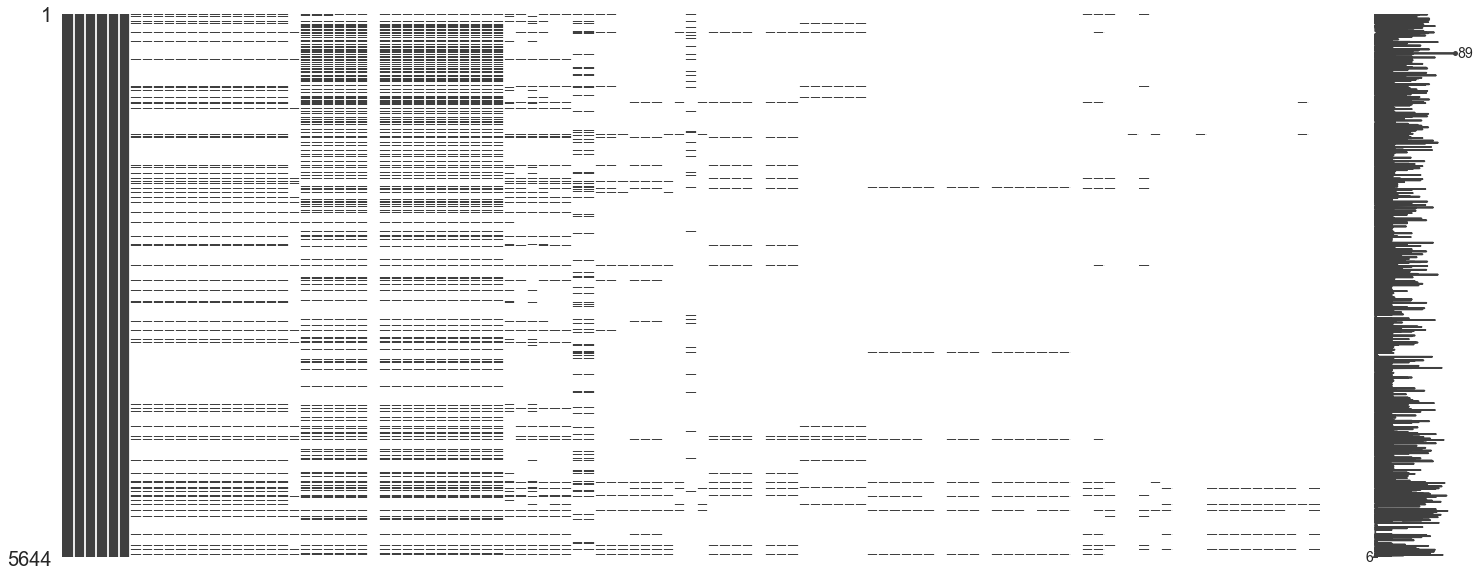

In [5]:
missingno.matrix(df);

---
## / Pandas Profiling

Pandas Profile it's an amazing lib to get a quickly exploratory analysis.

In [27]:
if pandas_profiling_executor:
    profile = pdp.ProfileReport(df, minimal=True, title='COVID-19 - Hospital Albert Einstein BR')
    profile.to_file(output_file=pandas_profiling_file)
    #pandas_profiling_link = pandas_profiling_file
    #print("pandas_profiling_link changed to {}".format(pandas_profiling_file))
    
HTML('<a href="{href}" target="_blank">{link_name}</a>'.format(href=pandas_profiling_link,
                                                               link_name=pandas_profiling_file))

---
## / Resume about pandas Profiling

We have a lot of features that has missing values,

To processind the dataset, we'll divide the columns in three categories:

- `cols_convert_to_binary`: Columns to be replaced by boolean values (0, 1).
- `cols_categorical`:  Columns to be replaced by numeric values in encoder.
- `cols_invalid`: Columns to be removed because it's ID or have no data available.

In [7]:
cols_convert_to_binary = ["SARS-Cov-2 exam result", "Respiratory Syncytial Virus", "Influenza A", "Influenza B",
                         "Parainfluenza 1", "CoronavirusNL63", "Rhinovirus/Enterovirus", "Coronavirus HKU1",
                         "Parainfluenza 3", "Chlamydophila pneumoniae", "Adenovirus", "Parainfluenza 4",
                         "Coronavirus229E", "CoronavirusOC43", "Inf A H1N1 2009", "Bordetella pertussis", 
                         "Metapneumovirus", "Parainfluenza 2", "Influenza B, rapid test", "Influenza A, rapid test",
                         "Strepto A", "Urine - Esterase", "Urine - Hemoglobin", "Urine - Bile pigments",
                         "Urine - Ketone Bodies", "Urine - Urobilinogen", "Urine - Protein", "Urine - Hyaline cylinders",
                         "Urine - Granular cylinders", "Urine - Yeasts", ]

cols_categorical = ["Urine - Aspect", "Urine - Crystals", "Urine - Leukocytes", "Urine - Color"]

cols_invalid = ["Patient ID", "Mycoplasma pneumoniae", "Fio2 (venous blood gas analysis)", "Urine - pH",
                "Urine - Nitrite", "Urine - Sugar", "Partial thromboplastin time\xa0(PTT)\xa0", "Vitamin B12"]

In [8]:
def _convert_to_binary(value):
    positive_lst = [1, "positive", "detected", "present", "normal"]
    negative_lst = [0, "negative", "not_detected", "absent", "not_done"]
    if value in positive_lst:
        return 1
    elif value in negative_lst:
        return 0
    else:
        return value
    
    
def processing(dataset, cols_invalid=None, cols_categorical=None, cols_convert_to_binary=None):
    """
    docstring
    """
    temp = dataset.to_dict(orient="records")    
    df_processed = []
    
    # processing each record
    with tqdm(total=len(temp)) as pbar:
        for values in temp:
            if isinstance(cols_convert_to_binary, list):
                for col in cols_convert_to_binary:
                    values[col] = _convert_to_binary(values[col])

            if isinstance(cols_invalid, list):    
                for col in cols_invalid:
                    del values[col]

            if isinstance(cols_categorical, list):
                for col in cols_categorical:
                    values = _encoder(values)
        
            # add processed record
            df_processed.append(values)
            pbar.update(1)
        
    df_processed = pd.DataFrame(df_processed)
    return df_processed


def _encoder(value):
    filename = "cat_features_encoding.json"
    with open(filename, 'r') as filename:
        encoding = json.load(filename)
        
    for col in encoding.keys():        
        for i in encoding[col]:
            if value[col] == i:
                value[col] = encoding[col][i]             
        
    return value


def create_encoder(dataset, cat_features):
    """
    This function can create a Label Encoder for categorical features.
    
    A json file called "cat_features_encoding.json" will be saved on folder's script. This file can be used on _encoder function.
    Input
    - dataset (DataFrame, required): The DataFrame loaded from listings.csv.
    - cat_features (list, required): The categorical features list that you want to convert in numeric values.
    Output
    - encoding (dict): A dictionary with the encoder created. The same content of json file.
    """
    encoding = {}
    filename = "cat_features_encoding.json"
    for col in cat_features:
        temp = {}
        n_values = dataset[col].unique()
        i = 0
        for n in n_values:
            temp[str(n)] = i
            i += 1
        encoding[col] = temp
    
    # save json file encoder
    with open(filename, 'w') as filename:
        json.dump(encoding, filename)
        
    return encoding

---
## / LabelEncoder for categorical features

In [9]:
for col in cols_categorical:
    print(col, len(df[col].unique()))
    print(df[col].unique())
    print()

Urine - Aspect 5
[nan 'clear' 'cloudy' 'altered_coloring' 'lightly_cloudy']

Urine - Crystals 6
[nan 'Ausentes' 'Urato Amorfo --+' 'Oxalato de Cálcio +++'
 'Oxalato de Cálcio -++' 'Urato Amorfo +++']

Urine - Leukocytes 32
[nan '38000' '5942000' '32000' '22000' '<1000' '3000' '16000' '7000'
 '5300' '1000' '4000' '5000' '10600' '6000' '2500' '2600' '23000' '124000'
 '8000' '29000' '2000' '624000' '40000' '3310000' '229000' '19000' '28000'
 '10000' '4600' '77000' '43000']

Urine - Color 5
[nan 'light_yellow' 'yellow' 'orange' 'citrus_yellow']



In [10]:
create_encoder(df, cols_categorical)

{'Urine - Aspect': {'nan': 0,
  'clear': 1,
  'cloudy': 2,
  'altered_coloring': 3,
  'lightly_cloudy': 4},
 'Urine - Crystals': {'nan': 0,
  'Ausentes': 1,
  'Urato Amorfo --+': 2,
  'Oxalato de Cálcio +++': 3,
  'Oxalato de Cálcio -++': 4,
  'Urato Amorfo +++': 5},
 'Urine - Leukocytes': {'nan': 0,
  '38000': 1,
  '5942000': 2,
  '32000': 3,
  '22000': 4,
  '<1000': 5,
  '3000': 6,
  '16000': 7,
  '7000': 8,
  '5300': 9,
  '1000': 10,
  '4000': 11,
  '5000': 12,
  '10600': 13,
  '6000': 14,
  '2500': 15,
  '2600': 16,
  '23000': 17,
  '124000': 18,
  '8000': 19,
  '29000': 20,
  '2000': 21,
  '624000': 22,
  '40000': 23,
  '3310000': 24,
  '229000': 25,
  '19000': 26,
  '28000': 27,
  '10000': 28,
  '4600': 29,
  '77000': 30,
  '43000': 31},
 'Urine - Color': {'nan': 0,
  'light_yellow': 1,
  'yellow': 2,
  'orange': 3,
  'citrus_yellow': 4}}

In [11]:
df_processed = processing(df, cols_invalid=cols_invalid, cols_categorical=cols_categorical,
                         cols_convert_to_binary=cols_convert_to_binary)

print(df_processed.shape)
df_processed.head()

100%|█████████████████████████████████████████████████████████████████████████████| 5644/5644 [00:08<00:00, 692.36it/s]


(5644, 103)


,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,13,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,0,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Columns: 103 entries, Patient age quantile to ctO2 (arterial blood gas analysis)
dtypes: float64(98), int64(5)
memory usage: 4.4 MB


---
## / Relevant features

Using correlation we can filter relevant features on this dataset. The correlation will be applied in target_col `SARS-Cov-2 exam result`.

In [13]:
# Correlation features
cor = df_processed.corr()
cor_target = abs(cor[target_col])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.05].sort_values(ascending=False)

df_cols_stats = pd.DataFrame(relevant_features[1:])
df_cols_stats.reset_index(inplace=True)
df_cols_stats.columns = ["column", "correlation with exam result"]
df_cols_stats = pd.merge(df_cols_stats, df_missing, on="column")
df_cols_stats.head(20)

,column,correlation with exam result,missing percentage
0,pCO2 (arterial blood gas analysis),0.323977,99.52
1,pH (arterial blood gas analysis),0.314820,99.52
2,pO2 (arterial blood gas analysis),0.312537,99.52
3,Arteiral Fio2,0.310583,99.65
4,Ionized calcium,0.305113,99.11
5,Urine - Leukocytes,0.290682,98.76
6,Leukocytes,0.288508,89.33
7,Platelets,0.282268,89.33
8,ctO2 (arterial blood gas analysis),0.267457,99.52
9,Total CO2 (arterial blood gas analysis),0.249422,99.52


Almost all of relevant features has a high number of missing values.

I'll trying to get a mix of correlation and missing percentage that I think that it's good enough.

In [14]:
cols_pairplot_filter = df_cols_stats[df_cols_stats["missing percentage"] < 90]["column"].tolist()
cols_pairplot_filter.append(target_col) # add target_col to the columns

df_cols_stats[df_cols_stats["missing percentage"] < 90]

,column,correlation with exam result,missing percentage
6,Leukocytes,0.288508,89.33
7,Platelets,0.282268,89.33
11,Monocytes,0.197333,89.35
12,Eosinophils,0.192609,89.33
18,Rhinovirus/Enterovirus,0.151724,76.05
20,"Patient addmited to regular ward (1=yes, 0=no)",0.142437,0.00
28,Red blood Cells,0.121320,89.33
33,Mean platelet volume,0.108836,89.39
34,Hemoglobin,0.104775,89.32
38,Hematocrit,0.099120,89.32


In [15]:
df_processed[cols_pairplot_filter].groupby(by=target_col).count().transpose()

SARS-Cov-2 exam result,0,1
Leukocytes,519,83
Platelets,519,83
Monocytes,518,83
Eosinophils,519,83
Rhinovirus/Enterovirus,1240,112
"Patient addmited to regular ward (1=yes, 0=no)",5086,558
Red blood Cells,519,83
Mean platelet volume,518,81
Hemoglobin,520,83
Hematocrit,520,83


---
## / Pairplot

The pairplot created by Seaborn it's very useful to understand the behavior of a specific column between others columns of the dataset.

We'll check how the **relevant features** are distributed considering `SARS-Cov-2 exam result`.

Wall time: 1min 13s


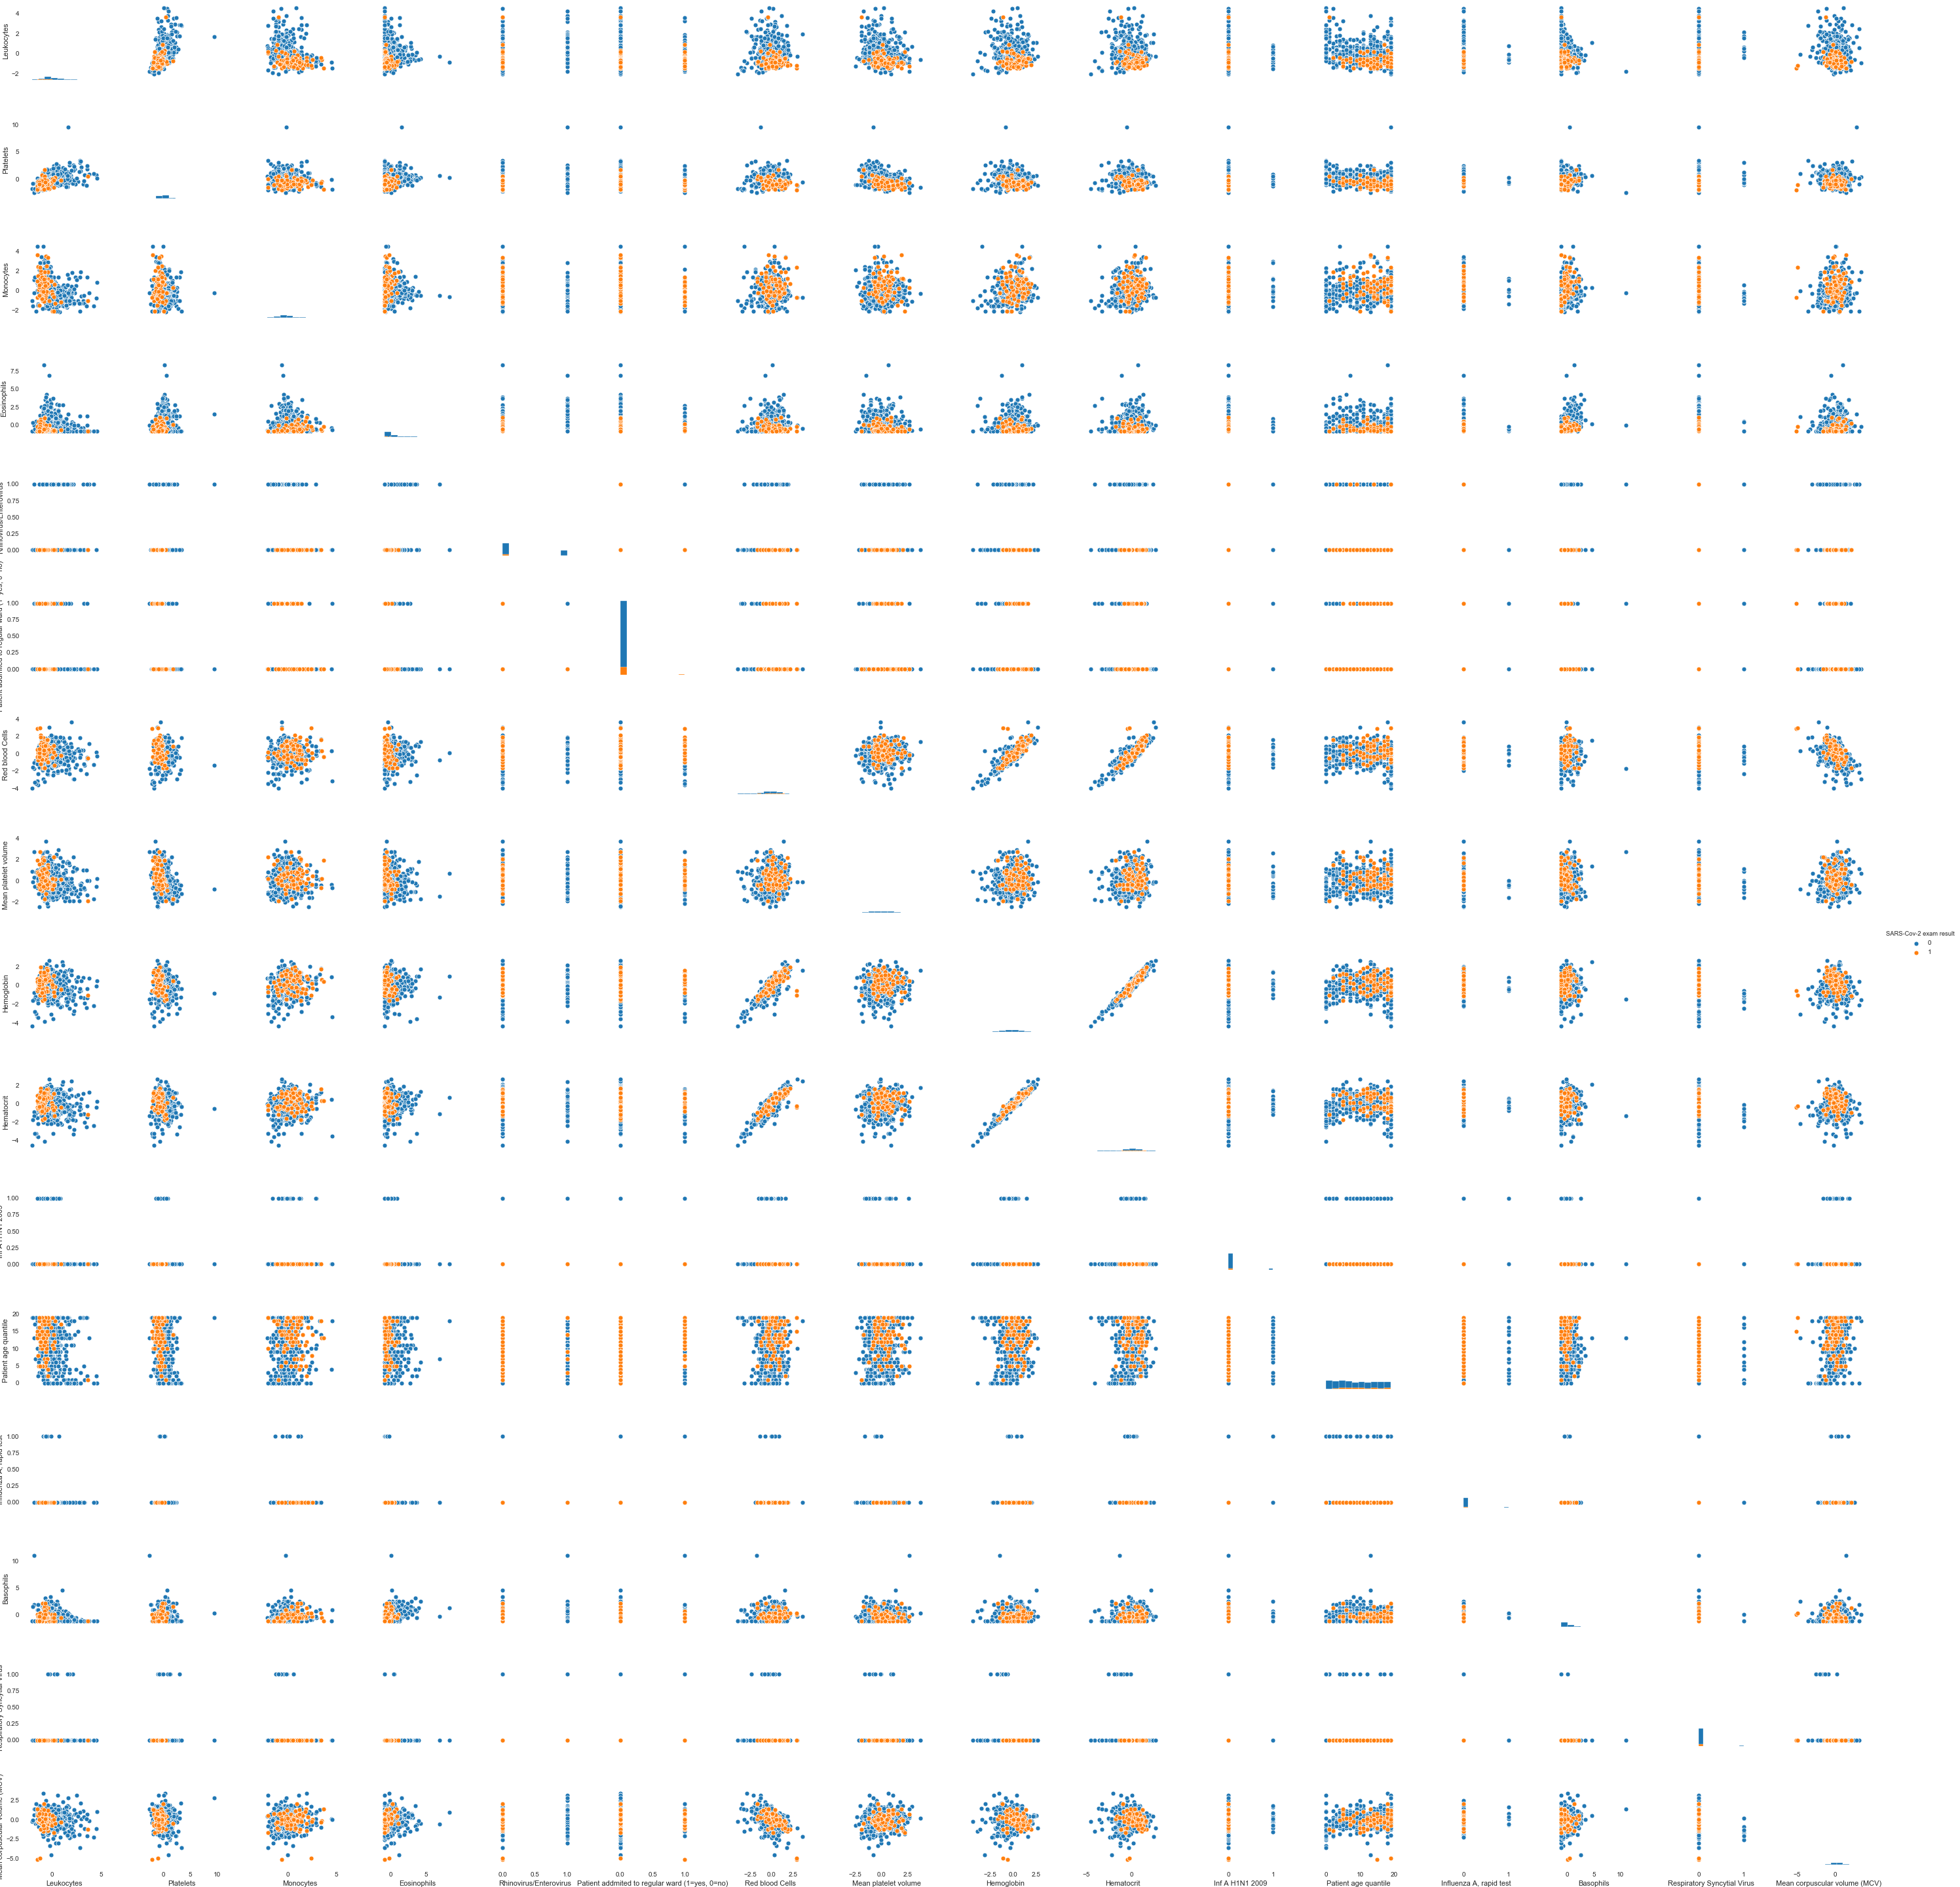

<Figure size 2992.75x2880 with 0 Axes>

In [16]:
%%time
pairplot_file = "pairplot.png"

sns.pairplot(df_processed[cols_pairplot_filter], hue=target_col, diag_kind="hist", dropna=True)
plt.savefig(pairplot_file)

plt.clf() # Clean parirplot figure from sns

Image(filename=pairplot_file) # Show pairplot as image

In [17]:
# Download image
HTML('<a href="{href}" target="_blank">Download image</a>'.format(href=pairplot_file))

We can see that these selected features has a good distribution between values of the target_col `SARS-Cov-2 exam result`.

I don't know if this distribution make sense in the health sector, but seeing only in the data for this small dataset, we can see that.

---

# / Modeling

## / Filling missing values

Filling **missing values** in this dataset will be a challenge because the percentage of missing values it's very high.

We'll get the relevant features that has more than 10% of the values, for these columns we'll use KNNImputer to complete missing values.

In [18]:
temp = df_processed[cols_pairplot_filter]

imputer = KNNImputer(n_neighbors=2)
temp = imputer.fit_transform(temp.values)

X = pd.DataFrame(temp, columns=cols_pairplot_filter)
X.head()

,Leukocytes,Platelets,Monocytes,Eosinophils,Rhinovirus/Enterovirus,"Patient addmited to regular ward (1=yes, 0=no)",Red blood Cells,Mean platelet volume,Hemoglobin,Hematocrit,Inf A H1N1 2009,Patient age quantile,"Influenza A, rapid test",Basophils,Respiratory Syncytial Virus,Mean corpuscular volume (MCV),SARS-Cov-2 exam result
0,1.654374,-0.253615,-0.351560,-0.835508,0.0,0.0,0.639730,0.010677,0.760860,0.888839,0.5,13.0,0.0,-1.140144,0.0,0.276354,0.0
1,-0.094610,-0.517413,0.357547,1.482158,1.0,0.0,0.102004,0.010677,-0.022340,0.236515,0.0,17.0,0.0,-0.223767,0.0,0.166192,0.0
2,-0.310277,0.054149,-1.100061,-0.182347,0.0,0.0,0.613284,0.627739,0.604220,0.556955,0.0,8.0,0.0,0.387152,0.0,-0.244413,0.0
3,-0.185051,-0.630469,0.725232,-0.287696,0.5,0.0,1.062859,0.347255,1.199452,1.197835,0.0,5.0,0.0,0.081693,0.0,-0.034104,0.0
4,-0.638646,-0.529975,-0.443481,-0.730159,1.0,0.0,-0.338755,0.010677,-0.022340,-0.175479,0.0,15.0,0.0,-0.681955,0.0,0.366487,0.0


## / Split in X and Y

In this section we'll split the features `X` and the answer `Y`.

In [19]:
y = X[target_col].values
X.drop(columns=[target_col], inplace=True)

## / Unbalanced classes

Houston. We have a problem! o/

We have **unbalanced classes**. See below the numbers of each classes.

Class 0: [5086] - (90.11%)
Class 1: [558] - (9.89%)


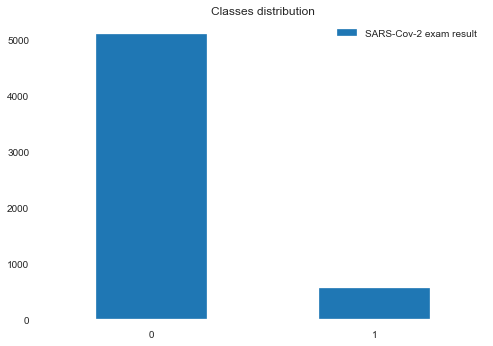

In [20]:
temp = pd.DataFrame(df_processed[target_col].value_counts())

for each in range(len(temp)):
    percentage = temp.values[each]/sum(temp.values)
    percentage = round(percentage[0]*100, 2)
    print("Class {ix}: {qty} - ({percentage}%)".format(ix=temp.index[each], qty=temp.values[each], percentage=percentage))

df_processed["SARS-Cov-2 exam result"].value_counts().plot(kind="bar", title="Classes distribution", legend=True, rot=1);

## / Class weight

To solve the **unbalanced classes** we will compute class weight and use it on the algorithms.

In [21]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

class_weights = {
    0: class_weights[0],
    1: class_weights[1]
}

print(class_weights)

{0: 0.5548564687377113, 1: 5.057347670250896}


## / Split in train and test

Here we'll split the datasets (`X`, `Y`) again, but now, in **train** and **test**.

In [22]:
# Split the dataset in train and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print("train size:", len(X_train))
print("test size:", len(X_test))

train size: 3781
test size: 1863


## / Random Forest

In [23]:
%%time
clf = RandomForestClassifier(n_estimators=50, criterion='gini', random_state=0, 
                             min_samples_leaf=5, min_samples_split=5,
                             class_weight=class_weights, n_jobs=-1)

clf.fit(X_train, y_train)

scores = cross_val_score(clf, X, y, cv=5)
y_pred = clf.predict(X_test)

print("Accuracy (cross-validation): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print()
print(classification_report(y_test, y_pred, digits=4))

Accuracy (cross-validation): 0.98 (+/- 0.01)

              precision    recall  f1-score   support

         0.0     0.9976    0.9935    0.9955      1685
         1.0     0.9405    0.9775    0.9587       178

    accuracy                         0.9919      1863
   macro avg     0.9691    0.9855    0.9771      1863
weighted avg     0.9922    0.9919    0.9920      1863

Wall time: 4.84 s


## / GridSearchCV

In [24]:
%%time

parameters = {'n_estimators':[25, 50, 100, 200, 300],
             "min_samples_leaf": [5, 10, 15, 20],
             "min_samples_split": [5, 10, 15, 20],
             "criterion": ["gini", "entropy"]}

model = RandomForestClassifier(random_state=0, class_weight=class_weights, n_jobs=-1)
clf = GridSearchCV(model, parameters, cv=5, verbose=2, n_jobs=-1)
clf.fit(X_train, y_train)
clf = clf.best_estimator_
preds = clf.predict(X_test)
print(classification_report(y_test, preds, digits=4))
clf

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  3.1min finished


              precision    recall  f1-score   support

         0.0     0.9976    0.9935    0.9955      1685
         1.0     0.9405    0.9775    0.9587       178

    accuracy                         0.9919      1863
   macro avg     0.9691    0.9855    0.9771      1863
weighted avg     0.9922    0.9919    0.9920      1863

Wall time: 3min 5s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.5548564687377113,
                                     1: 5.057347670250896},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

# / Conclusions

We have few samples for **positive cases** in `SARS-Cov-2 exam result` feature and for this small dataset of positive cases, we have a lot of missing values that doesn't provide any trust that this model will works in the real world. We filled a lot of missing values in the dataset and that it's not good.

In the meantime, I think that this study can help advance knowledge about **COVID-19**.

I hope that more data about clinical spectrum can be provided. In the future, we can provide better models or understand the impacts of the coronavírus on our bodies.